### Importing Necessary Packages

In [2]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
import time
import warnings
from sklearn.metrics import classification_report

import re

2025-05-22 20:48:54.616648: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-22 20:48:54.630864: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747936134.648065 1814995 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747936134.653292 1814995 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747936134.666214 1814995 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

### Upload dataset

In [3]:
# Original Dataset review
original_df_train = pd.read_csv('./train.csv')
original_dt_test = pd.read_csv('./test.csv')

In [4]:
original_df_train


,2,Stuning even for the non-gamer,This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^
0,2,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
1,2,Amazing!,This soundtrack is my favorite music of all ti...
2,2,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
3,2,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."
4,2,an absolute masterpiece,I am quite sure any of you actually taking the...
...,...,...,...
3599994,1,Don't do it!!,The high chair looks great when it first comes...
3599995,1,"Looks nice, low functionality",I have used this highchair for 2 kids now and ...
3599996,1,"compact, but hard to clean","We have a small house, and really wanted two o..."
3599997,1,what is it saying?,not sure what this book is supposed to be. It ...


### Data Preprocessing Step

In [7]:
# The first line has been made into a heading for readability.
train_df = pd.read_csv('./train.csv', header=None, names=['labels', 'title', 'text'])
test_df = pd.read_csv('./test.csv', header=None, names=['labels', 'title', 'text'])

In [8]:
train_df

,labels,title,text
0,2,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...
1,2,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
2,2,Amazing!,This soundtrack is my favorite music of all ti...
3,2,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
4,2,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."
...,...,...,...
3599995,1,Don't do it!!,The high chair looks great when it first comes...
3599996,1,"Looks nice, low functionality",I have used this highchair for 2 kids now and ...
3599997,1,"compact, but hard to clean","We have a small house, and really wanted two o..."
3599998,1,what is it saying?,not sure what this book is supposed to be. It ...


In [9]:
train_df = train_df.drop(columns=['title'])
test_df = test_df.drop(columns=['title'])

In [10]:
train_df

,labels,text
0,2,This sound track was beautiful! It paints the ...
1,2,I'm reading a lot of reviews saying that this ...
2,2,This soundtrack is my favorite music of all ti...
3,2,I truly like this soundtrack and I enjoy video...
4,2,"If you've played the game, you know how divine..."
...,...,...
3599995,1,The high chair looks great when it first comes...
3599996,1,I have used this highchair for 2 kids now and ...
3599997,1,"We have a small house, and really wanted two o..."
3599998,1,not sure what this book is supposed to be. It ...


In [11]:
train_df['labels'] = train_df['labels'].map({1: 0, 2: 1})
test_df['labels'] = test_df['labels'].map({1: 0, 2: 1})

In [12]:
train_df

,labels,text
0,1,This sound track was beautiful! It paints the ...
1,1,I'm reading a lot of reviews saying that this ...
2,1,This soundtrack is my favorite music of all ti...
3,1,I truly like this soundtrack and I enjoy video...
4,1,"If you've played the game, you know how divine..."
...,...,...
3599995,0,The high chair looks great when it first comes...
3599996,0,I have used this highchair for 2 kids now and ...
3599997,0,"We have a small house, and really wanted two o..."
3599998,0,not sure what this book is supposed to be. It ...


In [13]:
negatives_train = train_df[train_df["labels"] == 0]
positives_train = train_df[train_df["labels"] == 1]

negatives_test = test_df[test_df["labels"] == 0]
positives_test = test_df[test_df["labels"] == 1]

subset_size_train = 500_000
subset_size_test = 50_000
neg_samples_train = negatives_train.sample(n=subset_size_train, random_state=42)
pos_samples_train = positives_train.sample(n=subset_size_train, random_state=42)

neg_samples_test = negatives_test.sample(n=subset_size_test, random_state=42)
pos_samples_test = positives_test.sample(n=subset_size_test, random_state=42)

# New balanced dataset creation
balanced_df_train = pd.concat([neg_samples_train, pos_samples_train]).sample(frac=1, random_state=42)  # Shuffling
balanced_df_test = pd.concat([neg_samples_test,pos_samples_test]).sample(frac=1,random_state=42)
# Results of creation new dataset
print(balanced_df_train["labels"].value_counts())  # 500K negative, 500K positive 
print(f"New train dataset size: {len(balanced_df_train)}")  # 1M totally
print(balanced_df_test["labels"].value_counts()) # 50K negative and 50K positive
print(f"New test dataset size:{len(balanced_df_test)}") # 100K totally

labels
1    500000
0    500000
Name: count, dtype: int64
New train dataset size: 1000000
labels
1    50000
0    50000
Name: count, dtype: int64
New test dataset size:100000


In [15]:
import re

def clean_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)  # removing URL
    text = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", text)  # cleaning special character
    text = re.sub(r"\s{2,}", " ", text)  # remove extra space
    return text.strip()

In [16]:
balanced_df_train['text'] = balanced_df_train['text'].apply(clean_text)
balanced_df_test['text'] = balanced_df_test['text'].apply(clean_text)

In [17]:
print(balanced_df_train.isnull().sum())  # Checking for null value
print(balanced_df_train.describe())

labels    0
text      0
dtype: int64
          labels
count  1000000.0
mean         0.5
std          0.5
min          0.0
25%          0.0
50%          0.5
75%          1.0
max          1.0


In [21]:
train_texts = balanced_df_train["text"]
test_texts = balanced_df_test["text"]
train_labels = balanced_df_train["labels"]
test_labels = balanced_df_test["labels"]

In [28]:
train_texts

3225001    If you want a cheaper price, directly go to de...
967779     At first glance this would appear to be a grea...
937749     Undoubtedly Hepburn's most accomplished perfor...
326718     If I were them, I wouldn't find a lot of these...
803676     The only thing resembling Jon on this release ...
                                 ...                        
2965866    I've been listening to this guy drone on for a...
1205995    This book is really basic coverage of a lot of...
2177960    The side and roof panels are very thin, I was ...
1512557    I have used and been very pleased with this pr...
3298972    I bought this book for my son based on a recen...
Name: text, Length: 1000000, dtype: object

### Tokenization and Training

In [23]:
vocab_size = 10000        # Maximum number of words to keep
max_length = 200          # Max review length (in words)
oov_token = "<OOV>"    # Out-of-vocabulary token for unseen words
embedding_dim = 64        # Dimension of embedding vector
trunc_type='post'
padding_type='post'

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(train_texts)
#tokenizer.fit_on_texts(test_texts)

In [24]:
tokenizer.document_count

1000000

In [25]:
train_sequences = tokenizer.texts_to_sequences(train_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

In [26]:
train_padded = pad_sequences(
    train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type
)
test_padded = pad_sequences(
    test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type
)


In [29]:
# converting the labels to numpy series
train_labels_np = train_labels.to_numpy()  # veya train_labels.values
test_labels_np  = test_labels.to_numpy()


train_ds = TensorDataset(
    torch.LongTensor(train_padded),
    torch.FloatTensor(train_labels_np)
)
test_ds = TensorDataset(
    torch.LongTensor(test_padded),
    torch.FloatTensor(test_labels_np)
)


In [30]:
batch_size = 128
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size)

#### LSTM model desining and hyperparameters

In [31]:
vocab_size    = 10000      
embed_dim     = 64
hidden_dim    = 128
n_layers      = 4
bidirectional = True
dropout       = 0.2
lr            = 1e-4
epochs        = 20

In [32]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim,
                 n_layers=2, bidirectional=True, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim,
                            hidden_dim,
                            num_layers=n_layers,
                            bidirectional=bidirectional,
                            batch_first=True)
        self.dropout = nn.Dropout(dropout)
        fc_in = hidden_dim * (2 if bidirectional else 1)
        self.fc = nn.Linear(fc_in, 1)
        
    def forward(self, x):
        x, _ = self.embedding(x), None            # [B, T] → [B, T, E]
        lstm_out, _ = self.lstm(x)                # [B, T, H*D]
        
        if self.lstm.bidirectional:
            h_fwd = lstm_out[:, -1, :self.lstm.hidden_size]
            h_bwd = lstm_out[:,  0, self.lstm.hidden_size:]
            h = torch.cat([h_fwd, h_bwd], dim=1)
        else:
            h = lstm_out[:, -1, :]
        h = self.dropout(h)
        return torch.sigmoid(self.fc(h)).squeeze()


In [34]:
model= LSTMClassifier(vocab_size, embed_dim, hidden_dim,
                           n_layers=n_layers,
                           bidirectional=bidirectional,
                           dropout=dropout).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


#### LSTM training

In [35]:
for epoch in range(1, epochs+1):
    model.train()
    train_loss, train_acc = 0.0, 0.0
    for X, y in tqdm(train_loader,desc=f"Epoch {epoch}/{epochs} [Train]", leave=False):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        preds = model(X)
        loss  = criterion(preds, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc  += ((preds>=0.5).float() == y).float().mean().item()
    train_loss /= len(train_loader)
    train_acc  /= len(train_loader)
    
    model.eval()
    val_loss, val_acc = 0.0, 0.0
    with torch.no_grad():
        for X, y in tqdm(test_loader,desc=f"Epoch {epoch}/{epochs} [Valid]",leave=False):
            X, y = X.to(device), y.to(device)
            preds = model(X)
            loss  = criterion(preds, y)
            val_loss += loss.item()
            val_acc  += ((preds>=0.5).float() == y).float().mean().item()
    val_loss /= len(test_loader)
    val_acc  /= len(test_loader)
    
    print(f"Epoch {epoch:02d} — "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

Epoch 01 — Train Loss: 0.3659, Train Acc: 0.8342 | Val Loss: 0.2838, Val Acc: 0.8807


Epoch 02 — Train Loss: 0.2639, Train Acc: 0.8908 | Val Loss: 0.2439, Val Acc: 0.9008


Epoch 03 — Train Loss: 0.2333, Train Acc: 0.9052 | Val Loss: 0.2259, Val Acc: 0.9087


Epoch 04 — Train Loss: 0.2136, Train Acc: 0.9146 | Val Loss: 0.2105, Val Acc: 0.9158


Epoch 05 — Train Loss: 0.2001, Train Acc: 0.9208 | Val Loss: 0.2023, Val Acc: 0.9197


Epoch 06 — Train Loss: 0.1897, Train Acc: 0.9255 | Val Loss: 0.2008, Val Acc: 0.9192


Epoch 07 — Train Loss: 0.1808, Train Acc: 0.9294 | Val Loss: 0.1927, Val Acc: 0.9241


Epoch 08 — Train Loss: 0.1737, Train Acc: 0.9328 | Val Loss: 0.1929, Val Acc: 0.9245


Epoch 09 — Train Loss: 0.1668, Train Acc: 0.9358 | Val Loss: 0.1940, Val Acc: 0.9244


Epoch 10 — Train Loss: 0.1608, Train Acc: 0.9384 | Val Loss: 0.1870, Val Acc: 0.9272


Epoch 11 — Train Loss: 0.1548, Train Acc: 0.9413 | Val Loss: 0.1822, Val Acc: 0.9289


Epoch 12 — Train Loss: 0.1492, Train Acc: 0.9437 | Val Loss: 0.1847, Val Acc: 0.9284


Epoch 13 — Train Loss: 0.1441, Train Acc: 0.9458 | Val Loss: 0.1837, Val Acc: 0.9296


Epoch 14 — Train Loss: 0.1383, Train Acc: 0.9483 | Val Loss: 0.1904, Val Acc: 0.9283


Epoch 15 — Train Loss: 0.1333, Train Acc: 0.9507 | Val Loss: 0.1935, Val Acc: 0.9287


Epoch 16 — Train Loss: 0.1280, Train Acc: 0.9530 | Val Loss: 0.1885, Val Acc: 0.9289


Epoch 17 — Train Loss: 0.1228, Train Acc: 0.9552 | Val Loss: 0.1945, Val Acc: 0.9283


Epoch 18 — Train Loss: 0.1175, Train Acc: 0.9574 | Val Loss: 0.1976, Val Acc: 0.9281


Epoch 19 — Train Loss: 0.1118, Train Acc: 0.9598 | Val Loss: 0.2009, Val Acc: 0.9282


Epoch 20 — Train Loss: 0.1068, Train Acc: 0.9619 | Val Loss: 0.2088, Val Acc: 0.9269


In [44]:
## save model
!mkdir lstm_amazon_models
MODEL_PATH = "lstm_amazon_models/lstm_classifier.pt"
torch.save(model, MODEL_PATH)
print(f"Model kaydedildi → {MODEL_PATH}")

mkdir: cannot create directory ‘lstm_imdb_models’: File exists
Model kaydedildi → lstm_imdb_models/lstm_classifier_2.pt


In [ ]:
## upload model and eval with state_dict format
model = LSTMClassifier(
    vocab_size, embed_dim, hidden_dim,
    n_layers=n_layers,
    bidirectional=bidirectional,
    dropout=dropout
).to(device)

model.load_state_dict(torch.load(MODEL_PATH, map_location=device))

model.eval()

In [45]:
# without statedict format
model = torch.load("lstm_imdb_models/lstm_classifier_2.pt", map_location=device)


/tmp/ipykernel_1788972/304414613.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("lstm_imdb_models/lstm_classifier_2.pt", map_location=device)


Accuracy : 0.9269
Precision: 0.9203
Recall   : 0.9348
F1-Score : 0.9275
Confusion Matrix:
 [[45951  4049]
 [ 3262 46738]]


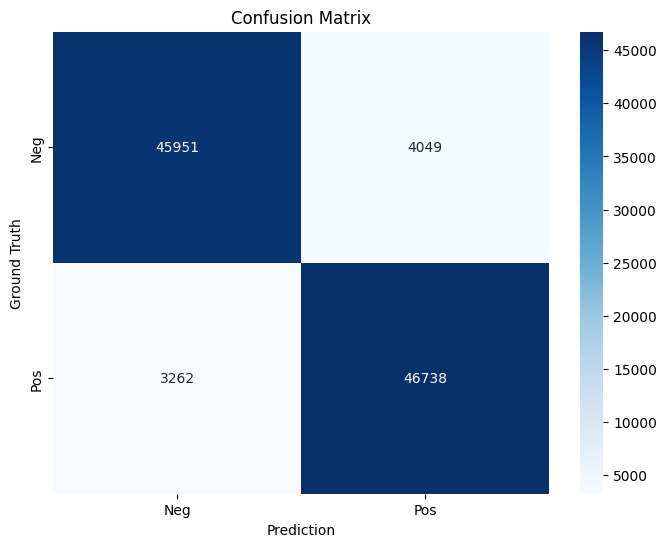

In [36]:
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


all_preds = []
all_labels = []
model.eval()
with torch.no_grad():
    for X, y in test_loader:
        X = X.to(device)
        preds = model(X)
        # 0.5 eşik ile ikili sınıf tahmini
        preds = (preds.cpu().numpy() >= 0.5).astype(int)
        all_preds.extend(preds)
        all_labels.extend(y.numpy().astype(int))

all_preds  = np.array(all_preds)
all_labels = np.array(all_labels)

# 4) Metrikleri hesapla
acc   = accuracy_score(all_labels, all_preds)
prec  = precision_score(all_labels, all_preds)
rec   = recall_score(all_labels, all_preds)
f1    = f1_score(all_labels, all_preds)
cm    = confusion_matrix(all_labels, all_preds)

print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-Score : {f1:.4f}")
print("Confusion Matrix:\n", cm)

# 5) Confusion Matrix’i görselleştir (opsiyonel)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Neg","Pos"],
            yticklabels=["Neg","Pos"])
plt.xlabel("Prediction")
plt.ylabel("Ground Truth")
plt.title("Confusion Matrix")
plt.show()

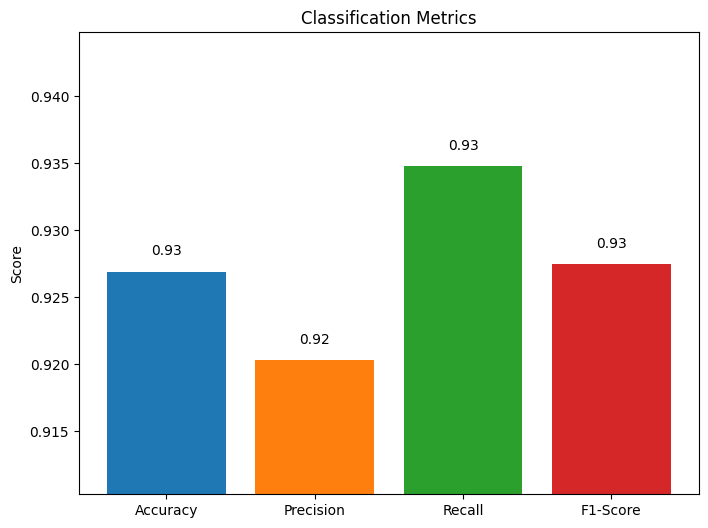

In [37]:
metrics = {
    "Accuracy" : acc,
    "Precision": prec,
    "Recall"   : rec,
    "F1-Score" : f1
}

# Dinamik y-ekseni aralığı: en düşük değerin hemen altından en yüksek değerin biraz üstüne
values = list(metrics.values())
min_val, max_val = min(values), max(values)
margin = 0.01  # %5 marjin
ymin = max(min_val - margin, 0)
ymax = min(max_val + margin, 1.0)

# Renk paleti (4 farklı renk)
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]

plt.figure(figsize=(8,6))
bars = plt.bar(metrics.keys(), metrics.values(), color=colors)
plt.ylim(ymin, ymax)
plt.ylabel("Score")
plt.title("Classification Metrics")

# Her bar'ın tepesine değer ekleyelim
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height + 0.001,
        f"{height:.2f}",
        ha="center",
        va="bottom"
    )

plt.show()

### Calculation of Metrics

In [ ]:
from torch.utils.data import DataLoader
from datasets import Dataset
import numpy as np
from tqdm import tqdm
#test_tokenized = test_tokenized.rename_columns({"label": "labels"})
testing_dataloader = DataLoader(test_tokenized, batch_size=128, shuffle=False)

model.eval()
preds = []
labels = []

with torch.no_grad():
    for batch in tqdm(testing_dataloader,desc="Prediction Progress",unit= "batch"):
        inputs = {k:v.to("cuda") for k,v in batch.items() if k != "label"}
        outputs = model(**inputs)
        logits = outputs.logits
        predictions = torch.argmax(logits,dim=-1).cpu().numpy()

        preds.extend(predictions)
        labels.extend(batch["label"].cpu().numpy())

preds = np.array(preds)
labels = np.array(labels)

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns
# Accuracy 
accuracy = accuracy_score(labels, preds)

# Precision, Recall, F1-score(average="binary" for 2 class )
precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")

# Confusion Matrix 
conf_matrix = confusion_matrix(labels, preds)

# Results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# 📌 **Confusion Matrix Visualization**
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# 📌 **Precision - Recall - F1 Score Bar Chart**
metrics = {"Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1 Score": f1}
plt.figure(figsize=(8,5))
sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette="viridis")
plt.ylim(0, 1)
plt.ylabel("Score")
plt.title("Evaluation Metrics")
plt.show()

### Manuel Testing 

In [ ]:
test_sentence = ["very good"]
inputs = tokenizer(test_sentence, padding=True, truncation=True, return_tensors="pt", max_length=512).to("cuda")
with torch.no_grad():
    output_of_manuel = model(**inputs)

predictions_of_manuel = torch.argmax(output_of_manuel.logits,dim=-1)

for sentence,prediction_of_manuel in zip(test_sentence,predictions_of_manuel):
    sentiment = "Negative" if prediction_of_manuel.item() == 1 else "Positive"
    print(f"Sentence: '{sentence}' => Sentiment: {sentiment}")

In [ ]:
print(prediction_of_manuel)

In [ ]:
# Cross data validation amazon to imdb model , otherwise.
# bir de hatalı yapanlarda bir bias var mı hata ayıklama,
# görselleştirmeyi düzenlemek gerekiyo, detaylı gözüksün değerler.
# 